# Recyclery volunteer data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

In [2]:
# Load 2008-2015 hours database
hours_1 = pd.read_csv('hours.2016.09.16a.csv', header=None,
                      names=['time_in', 'time_out', 'worker_id', 'w_type',
                             'w_type2', 'time_created', 'time_mod'],
                      parse_dates=[0, 1, 5, 6])

# Load 2015-2017 database
hours_2 = pd.read_csv('hours.2015.csv', header=None,
                       names=['worker_id', 'time_created', 'time_mod', 'time_in', 'time_out'],
                       parse_dates=[1, 2, 3, 4])

hours = hours_1.append(hours_2, ignore_index=True)

# Calculate shifts duration in hours
hours['duration'] = (hours['time_out'] - hours['time_in']) / np.timedelta64(1, 'h')

# Set index
hours.set_index('time_in', inplace=True, drop=False)
hours.sort_index(inplace=True)
hours.index = hours.index.tz_localize('UTC').tz_convert('US/Central')

# Select only shifts lasting less than 6 hours
hours = hours[(hours['duration'] > 0.167) & (hours['duration'] < 8.)]

In [3]:
# Load workers table
workers = pd.read_csv('_private_volunteers.csv', header=None,
                      names=['worker_id', 'name'], index_col = 0)

# Find the first shift for each worker
workers['joined'] = hours.groupby(by='worker_id').min()['time_in']
workers['last_shift'] = hours.groupby(by='worker_id').max()['time_in']
workers['time_involved'] = workers['last_shift'] - workers['joined']

## Monthly summary

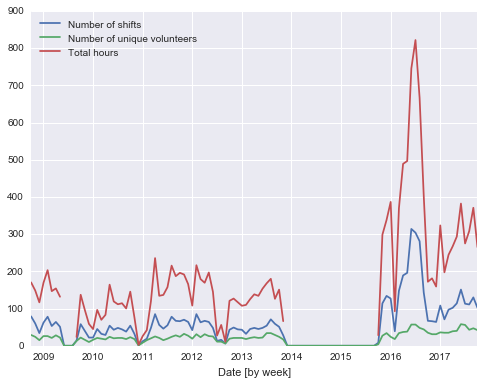

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

hours['worker_id'].resample('M').count().plot()
hours['worker_id'].resample('M').nunique().plot()
hours['duration'].resample('M').sum().plot()

ax.set_xlabel('Date [by week]')
plt.legend(['Number of shifts', 'Number of unique volunteers', 'Total hours'], loc='best')
plt.show()

## Shift duration
What does a typical shift look like?

Average shift length: 2.6 hours
Median shift length: 2.4 hours


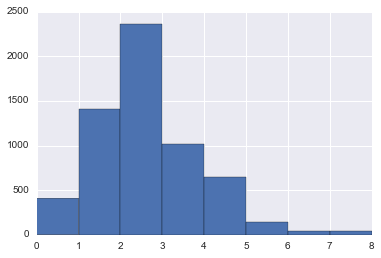

In [5]:
print 'Average shift length: {0:3.1f} hours'.format(hours['duration'].mean())
print 'Median shift length: {0:3.1f} hours'.format(hours['duration'].median())

fig = plt.figure(figsize=(6, 4))
plt.hist(hours['duration'], bins=range(9))
plt.xlabel('')
plt.show()

## Survival analysis
After a volunteer logs their first shift, do they stay involved? What is the likelihood that they will still be involved after N weeks?

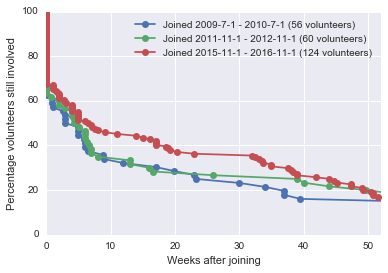

In [6]:
# For each worker, get time of first shift and last shift

fig = plt.figure(figsize=(6, 4))

join_range = [('2009-7-1', '2010-7-1'),
              ('2011-11-1', '2012-11-1'),
              ('2015-11-1', '2016-11-1')]

for d in join_range:
    cohort = workers[(workers['joined'] > d[0]) & (workers['joined'] < d[1])].copy()
    cohort['one'] = 1
    cohort = cohort.sort_values('time_involved')
    
    plt.plot(cohort.time_involved / np.timedelta64(1, 'W'),
         100.0*cohort.one.cumsum()[::-1] / cohort.one.sum(),
         label='Joined {0:s} - {1:s} ({2:d} volunteers)'.format(d[0], d[1], len(cohort)),
         marker='o')

plt.axis([0, 52, 0, 100])

plt.xlabel('Weeks after joining')
plt.ylabel('Percentage volunteers still involved')
plt.legend()
plt.show()

## How are shifts distributed throughout week and day?

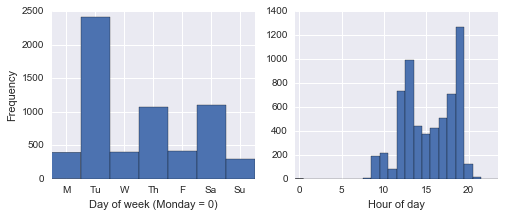

In [7]:
hours['dayofweek'] = hours.index.weekday
hours['hourofday'] = hours.index.hour

f, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(hours['dayofweek'], bins=np.arange(8)-0.5)
ax[0].set_xticklabels(['', 'M','Tu','W','Th','F','Sa','Su'])
ax[0].set_xlim([-0.5, 6.5])
ax[0].set_xlabel('Day of week (Monday = 0)')
ax[0].set_ylabel('Frequency')

ax[1].hist(hours['hourofday'], bins=np.arange(25)-0.5)
ax[1].set_xlim([-0.5, 23.5])
ax[1].set_xlabel('Hour of day')

plt.show()

## Has the distribution of volunteering times changed over the years?

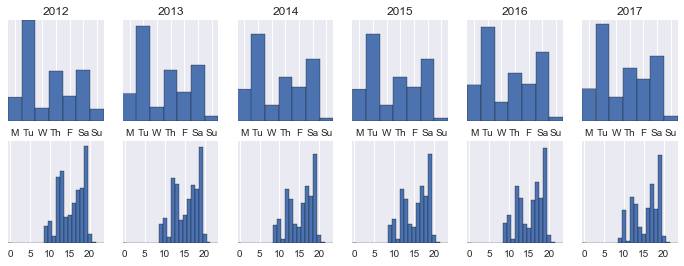

In [8]:
years = range(2012, 2018)

fig, ax = plt.subplots(2, len(years), figsize=(12, 4))
for i in range(len(years)):
    h_slice = hours[hours.index > '{0:d}-01-01'.format(years[i])]
    
    ax[0, i].hist(h_slice['dayofweek'], bins=np.arange(8)-0.5)
    ax[0, i].set_xticklabels(['', 'M','Tu','W','Th','F','Sa','Su'])
    ax[0, i].set_xlim([-0.5, 6.5])
    ax[0, i].set_yticks([])
    ax[0, i].set_title('{0:d}'.format(years[i]))
    
    ax[1, i].hist(h_slice['hourofday'], bins=np.arange(25)-0.5)
    ax[1, i].set_xlim([-0.5, 23.5])
    ax[1, i].set_yticks([])
    
plt.show()

## Distribution of hours by day

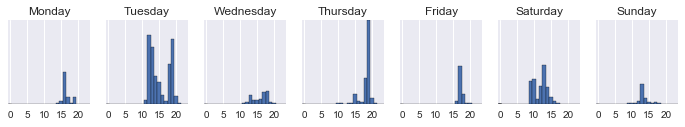

In [9]:
fig, ax = plt.subplots(1, 7, sharey=True, figsize=(12, 1.5))

for d in range(7):
    h_slice = hours[hours.dayofweek == d]
    
    ax[d].hist(h_slice['hourofday'], bins=np.arange(25)-0.5)
    ax[d].set_xlim([-0.5, 23.5])
    ax[d].set_yticks([])
    ax[d].set_title(h_slice.index.weekday_name[0])
    
plt.show()